**Previous**: [Multi-Layer Neural Net](GOL_NN.ipynb)

# Deep Learning with Game Of Life, Part IV
# Convolutional Neural Network

Starting with convolutional networks was a bit more tedious than the preceding parts, as it required iterating the understanding towards areas that were perhaps not so directly touched in the Deeplearning.ai [Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks/home/welcome) course. The course material was built on classification / object recognition problems, the last part covering face recognition and neural style transfer, but what I'm about to attempt here does not map exactly to these particular examples.

To learn the ropes I decided to go first for reproducing the three-layer fully connected network implemented in previous notebook with [Keras](https://keras.io/). 


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras as K
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, Nadam
import numpy as np
import time
from matplotlib import pyplot as plt
from IPython.display import HTML
from matplotlib import animation
%matplotlib inline

from utils import gol_utils as gol


It is really rather simple to create a Keras model. I'm using the functional API here, which makes the code a bit more concise. I have created the ```traindata.npz``` archive that contains the 60 training samples used in previous notebook, and the full 512 Moore neighborhoods and their resulting truth labels for training and validation. 

Not sure if it was a surprise to see that creating a model with 1:1 hyperparameters would not produce identical result. I ended up tuning the model with Dropout of 0.1 in the two first activation layers, and having very small l2 regulation in the backprop until the model produced 100% accuracy on the validation set, after learning for around 1500 epochs (which is much longer than what my hand-implemented model had). 

This could most probably be optimized to get closer to the rather impressive 160 epochs with 60 samples result that I got with my diy implementation, but I'm already looking forward towards delving into CNN architectures so I'm not going to iterate longer with the parameters here.

Fitting...
...Done. Validation accuracy 0.935546875 after 2000 epochs


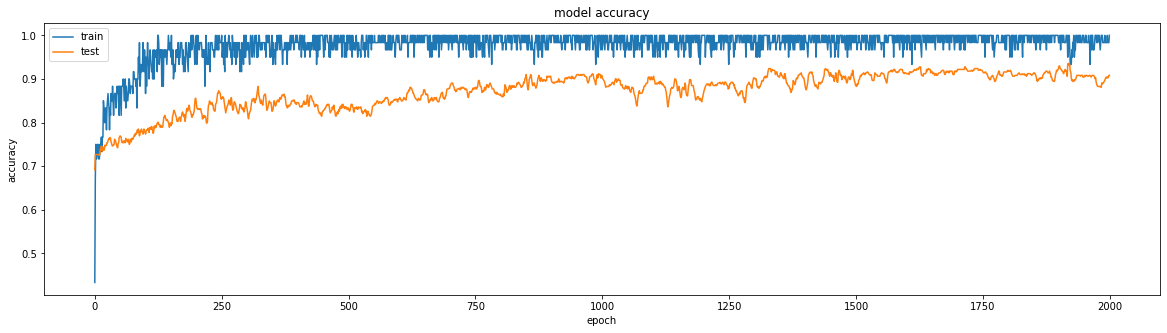

In [2]:
# Loading the train and validation datasets.
np.random.seed(2)
npzfile = np.load("data/traindata.npz")
train_set_x_3x3 = npzfile['train_set_x']
train_set_y_3x3 = npzfile['train_set_y']
test_set_x_3x3 = npzfile['test_set_x']
test_set_y_3x3 = npzfile['test_set_y']

reg = K.regularizers.l2(0.001)
inputs = Input((3,3)) #Size of a single example is 3,3 => flatten to get a 1-dim array 
x = Flatten()(inputs)
x = Dense(15, activation='tanh', activity_regularizer=reg)(x)
x = Dropout(0.3)(x)
x = Dense(15, activation='ReLU', activity_regularizer=reg)(x)
x = Dropout(0.3)(x)
x = Dense(15, activation='ReLU', activity_regularizer=reg)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_3x3 = Model(inputs=inputs, outputs=predictions)
model_3x3.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.901, beta_2=0.998, epsilon=1e-08, amsgrad=True),
              loss=K.losses.binary_crossentropy,
              metrics=['accuracy'])

filepath="data/dense_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=1000, mode='max')
print("Fitting...")
history = model_3x3.fit(train_set_x_3x3,
          train_set_y_3x3,
          epochs=2000,
          validation_data=(test_set_x_3x3, test_set_y_3x3),
          shuffle=True,
          verbose=0,
          callbacks=[checkpoint, early_stop])

val_acc = history.history['val_accuracy']

print("...Done. Validation accuracy " + str(np.max(val_acc)) + " after " + str(len(val_acc)) + " epochs")

plt.figure(figsize=(20,5))
plt.plot(history.history['accuracy'])
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### The Convolutional Challenge, 5x5 grid

My insipration here was Daniel Rapp's [cnn-gol](https://github.com/DanielRapp/cnn-gol) sample implemented with convnet.js. Also, having seen the impressive presentation of [YOLO algorithm presented in the Deeplearning.ai material](https://www.coursera.org/learn/convolutional-neural-networks/lecture/fF3O0/yolo-algorithm) I wanted to see if I can extrapolate my dense network implementation that predicted a single cell result looking at a 3x3 grid. Can I train a CNN network to predict a 3x3 grid result looking at 5x5 inputs? My hypothesis is that this should work, maybe not to 100% accuracy. Based on Daniel Rapp's example, this should be possible to expand into 9x9 grid and beyond, even though the anticipated human error rate grows when the grid grows, as it will be more and more difficult for a human to track what is going on. 

![predictions](images/extrapolation.png)

I started with a really simple model that takes in 5x5 grids and predicts 9 values (resulting 3x3 grid). There are ```2**25 = 33554432``` different permutations in a 5x5 grid, and there are ```512``` possible resulting grids. I was first thinking of using a 9-dimensional output and calculating the loss by averaging the error per grid cell, but when evaluating the permutations I came to think that the result could also be represented with a one-hot vector, which allows for using crossentropy loss functions. This will obviously not be very convenient with larger grids than this, but works for this particular scenario.

#### Creating the training set

I'm creating the training dataset by first picking 60000 random numbers from range ```0...2**25```. Then I generate the 5x5 training grids from the dataset values, apply the standard Game Of Life algorithm on each grid and create the one-hot label from the center 3x3 cells from the result. The training is done with 0.5 validation split, meaning that 30000 samples are used to train the model (around 1‰ of all possible permutations - i.e. _A LOT_ smaller training set compared to the full data body than with the 3x3 grid scenario)


In [3]:
#Create the training sample set of 100000 integers in range 0-2**25
np.random.seed(2)
dataset = set([])
excount = 60000

while len(dataset) < excount:
    dataset.add(np.random.randint(0,2**25))

In [4]:
from tensorflow.keras.utils import to_categorical

In [5]:
#Create actual training grids and the corresponding truth labels
train_set_x = np.empty((len(dataset), 5,5,1))
train_set_y = np.empty((len(dataset), 512))
indexes = np.empty((len(dataset)))
i = 0
for n in dataset:
    sample = gol.bitfield_n(n, 5)
    train_set_x[i] = sample.reshape(5,5,1)
    truth = gol.life_step_standard_rules(sample)
    truthindex = gol.bits_to_int(truth[1:4:, 1:4:].reshape(-1))
    indexes[i] = truthindex
    i = i + 1

train_set_y = to_categorical(indexes)
print("Done creating " + str(len(dataset)) + " samples")

Done creating 60000 samples


#### Building the model

I experimented quite a bit with the network architecture here, using multiple dense layers, trying different convolutions, optimizers, types of regularisation and other hyperparameter features that Keras so nicely supports. After some iterations, the model stabilized to two convolutional layers followed by a dense layer for final softmax prediction, using standard Adam optimizer. Applying a small dropout during training before the final layer made the model converge quite a bit faster than otherwise. Again, I'm sure that this model could be further optimized for faster learning, number of trainable parameters and performance. I'll pass that and move on to bigger grid, but first: here's my 5x5 prediction model that does a pretty good job. 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 5, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 30)          300       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 30)          930       
_________________________________________________________________
flatten_1 (Flatten)          (None, 270)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 270)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               138752    
Total params: 139,982
Trainable params: 139,982
Non-trainable params: 0
_____________________________________________________

/Users/aleksi.sitomaniemi/.pyenv/versions/3.9.4/envs/gol-deep/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


938/938 [==============================] - 4s 3ms/step - loss: 4.9872 - accuracy: 0.1190 - val_loss: 3.1948 - val_accuracy: 0.3179
Epoch 2/7
938/938 [==============================] - 3s 3ms/step - loss: 2.9508 - accuracy: 0.3858 - val_loss: 0.9474 - val_accuracy: 0.8178
Epoch 3/7
938/938 [==============================] - 3s 3ms/step - loss: 0.6552 - accuracy: 0.9131 - val_loss: 0.1557 - val_accuracy: 0.9935
Epoch 4/7
938/938 [==============================] - 3s 3ms/step - loss: 0.1185 - accuracy: 0.9978 - val_loss: 0.0558 - val_accuracy: 0.9991
Epoch 5/7
938/938 [==============================] - 3s 3ms/step - loss: 0.0442 - accuracy: 0.9999 - val_loss: 0.0277 - val_accuracy: 0.9994
Epoch 6/7
938/938 [==============================] - 3s 3ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 7/7
938/938 [==============================] - 3s 3ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
...Done. Validation acc

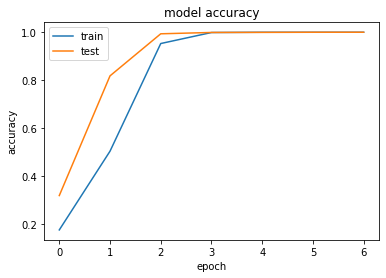

In [6]:
np.random.seed(2)
inputs = Input((5,5,1)) #Size of a single example is 5,5,1 (5x5, 1 channel only)
x = Conv2D(30, (3,3), strides=(1,1), activation='relu')(inputs) #30 convolutional filters of 3x3
x = Conv2D(30, (1,1), activation='tanh')(x) #30 convolutional filters of 1x1
x = Flatten()(x) #flatten the convolutions
x = Dropout(0.05)(x) #for a bit of regularisation, apply mild dropout before last activation
predictions = Dense(512, activation='softmax')(x) #predict softmax vector of size 512 

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss=K.losses.categorical_crossentropy,
             optimizer=K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
             metrics=['accuracy'])

model.summary()

history = model.fit(train_set_x, train_set_y,
          epochs=7,
          validation_split=0.5,
          shuffle=True,
          verbose=1)

val_acc = history.history['val_accuracy']

print("...Done. Validation accuracy " + str(np.max(val_acc)) + " after " + str(len(val_acc)) + " epochs")

plt.plot(history.history['accuracy'])
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### But is 30000 samples enough for validation?

I trained with 1‰ with the material, and validated with another 1‰. It is not positive that my model will predict all the permutations correctly, even though I'd say it is pretty good chance. To be sure tho, the following code will iterate through the whole space (33554432 permutations) and verify the model prediction against the original algorithm result. If you want to run it yourself, be my guest but it's going to take hours. For the sake of entertainment, the script below will print out statistics every 1000 samples. Trust me, it's going to work - I've run it overnight, and it ends up with zero failures, so we're all good (you can skip to next bit).

In [ ]:
from IPython.display import clear_output
   
correct = 0
wrong = 0
fails = set([])
start_time = time.time()
for x in range(0,2**25):
    bf = gol.bitfield_n(x, 5)
    if x % 1000 == 0:
        elapsed = time.time() - start_time
        clear_output(wait=True)
        hours, remainder = divmod(elapsed, 3600)
        minutes, seconds = divmod(remainder, 60)
        elapsedstr = '%02d:%02d:%02d' % (hours, minutes, seconds)
        print('{0:.2f}'.format(x/2**25*100) + "% done (" + str(x) + "), fail rate: " + '{0:.2f}'.format(len(fails)/(x+1)) + "% (" + str(len(fails)) + ") elapsed: " + elapsedstr)
        print(bf)
    predicted = np.argmax(model.predict(bf.reshape(1,5,5,1)))
    truth = gol.bits_to_int(gol.life_step_standard_rules(bf)[1:4:,1:4:].reshape(-1))
    if predicted != truth:
        fails.add(x)


#### This function has to be used with extreme care

Man oh man it was an adventure with a numpy rookie to get the predictions out in proper form for visualizing them on screen. The tricky (sic!) bit was to get a bit more familiar with numpy's ```stride_tricks``` functions, and after a serious headbanging session I started to get the result out as I wanted. It's funny that the documentation really has a warning **This function has to be used with extreme care, see notes** which does not make it any less intimidating. Through StackOverflow I found [Stuart Berg's blockwise view implementation](https://github.com/ilastik/lazyflow/blob/master/lazyflow/utility/blockwise_view.py) which helped a lot creating my own version. The main difference is that I need a partially overlapping window, therefore the original implementation was not directly feasible. In this scenario, the 2d game matrix is traversed through with a 5x5 window using steps of 3, i.e. the outer rim always overlaps with outer rim of the next/previous window. 

Since I did not want to resolve any padding issues, the gridsize in the below Python block needs to be **divisible by 9**. Otherwise feel free to experiment with the settings. 

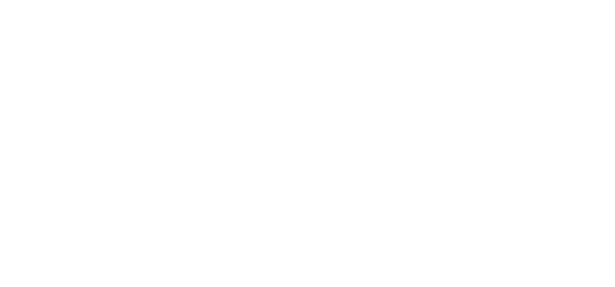

In [8]:
import timeit
# settings for the animation 
gridsize = 45 # Size of the grid (n times n square, n must be divisible by 9)
gens = 100    # How many generations are animated
ival = 100    # frame interval in milliseconds (default 100 for 10 fps)

# Create a random game grid of 50% density 
GAME = gol.generate(gridsize, 0.5)
#GAME = np.random.randint(2, size=(gridsize,gridsize))
GAME_REF = GAME

def split_it(a, gridsize, step):
    a1 = a[:, step:step + gridsize]
    a2 = a[:, step+gridsize:step+gridsize*2]
    a3 = a[:, step+gridsize*2:step+gridsize*3]
    r = np.concatenate(np.array([a1,a2,a3]))
    return r

def life_step_cnn_5(GRID):
    #create rim around the game area for torus-like operation
    expGame = np.pad(GRID,[(1,1),(1,1)], mode='wrap')
    gridsize = GRID.shape[0]
    assert(gridsize % 9 == 0) # make sure the gridsize is divisible by 9 
    multiplier = int(gridsize/3)
    blockshape = tuple((3,3)) # will be moving the 5x5 window in 3 by 3 steps
    intra_strides = expGame.strides
    inter_strides = tuple(intra_strides * np.array(blockshape))
    view = np.lib.stride_tricks.as_strided(expGame,
                                       shape=(multiplier, multiplier,5,5), 
                                       strides=(inter_strides+intra_strides))
    intvalues = np.argmax(model.predict(view.reshape(multiplier*multiplier,5,5,1)), axis=1)
    stripe = np.concatenate(np.array([gol.bitfield(result) for result in intvalues]), axis=1)
    preds = np.array([split_it(stripe, gridsize, step) for step in range(0, stripe.shape[1], gridsize*3)])
    return preds.reshape(gridsize,gridsize)


fig, (ax1, ax2) = plt.subplots(1,2)
ax1.axis("off")
ax2.axis("off")
fig.set_size_inches(10.8, 5.4)

ims = []

# To print out relative time used in calculations with the trained model & original GOL algo
#%timeit life_step_cnn_5(GAME)
#%timeit gol.life_step_standard_rules(GAME)

#render generations
for g in range(0,gens):
    im = ax1.imshow(GAME, animated=True)
    im2 = ax2.imshow(GAME_REF, animated=True)
    ims.append([im, im2])
    GAME = life_step_cnn_5(GAME)
    GAME_REF = gol.life_step_standard_rules(GAME_REF)
    
anim = animation.ArtistAnimation(fig,ims,interval=ival)
HTML(anim.to_html5_video())

### Resolving bigger grids at one go

So 5x5 was a walk in the park. How about bigger grids then? I tested first with a 9x9 grid, which seemed to be possible to predict pretty accurately after training a relatively small convnet. I wanted to try this with a bit bigger problem, say 30x30 grid. 

Nice thing here I can easily generate my training data set with the original GOL algorithm. The below python block creates the training set by iterating 10000 random initial positions for 4 generations, and the truth labels are autogenerated in the same process. Half of these samples are used for training, half for validation. Notice that ```20000 / 2**400 = 7.745183829698637e-117``` so the training occurs with a ridiculously small precentage of the full set.

In [9]:
np.random.seed(2)
gridsize = 32
seeds = 10000
gens = 4

x_train = np.empty((seeds*gens, gridsize, gridsize, 1))
y_train = np.empty((seeds*gens, (gridsize-2)**2))

#create train and test materials by initialising _seeds_ random grids and iterating them through _gens_ generations.
for idx in range(seeds):
    traingrid = gol.generate(gridsize, (np.random.randint(10) / 10.0))
    for gen in range(gens):
        x_train[(idx * gen) + gen] = traingrid.reshape(gridsize,gridsize,1)
        traingrid = gol.life_step_standard_rules(traingrid)
        y_train[(idx * gen) + gen] = traingrid[1:gridsize-1:, 1:gridsize-1:].reshape(-1,)

        

#### 30x30 grid prediction model

After experimenting with a number of different network architectures with about similar number of parameters (~1 million) I noticed that the one used for 5x5 grid actually worked best for me, just with a bit different nodes per layer ratio (50 to 1 instead of 30 to 30). With this setup the number of parameters stays reasonable for training on CPU. I also tried regularisation with Droput and L2, and a variety of activation functions, but finally the model simplified into two convolution layers and a dense layer for outputting the prediction.

For a 30x30 grid it would not be feasible to use softmax prediction so the loss cannot be categorical crossentropy. I used mean squared error here, which worked pretty nice and produced a very uniform result, with just a slight uncertainty (more on this below). The gridsize parameter used is 32 (30x30 grid expanded by (1,1) wrapped => 32x32).

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 50)        500       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 1)         51        
_________________________________________________________________
flatten_3 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 900)               810900    
Total params: 811,451
Trainable params: 811,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
625/625 [==============================] - 14s 22ms/step - loss: 0.0856 - mse: 0.0856 - val_loss: 0.0125 - va

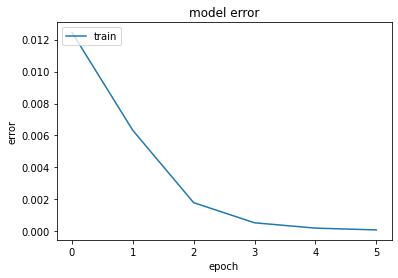

In [12]:
gridsize=32

inputs = Input((gridsize,gridsize,1)) #Size of a single example 
x = Conv2D(50, (3,3), strides=(1,1), activation='relu')(inputs) #100 convolutional filters of 3x3
x = Conv2D(1, (1,1), activation='tanh')(x) #1 1x1 filter
x = Flatten()(x) #flatten the convolutions
predictions = Dense((gridsize-2)**2, activation='relu')(x) #predict 400 activations

model_9 = Model(inputs=inputs, outputs=predictions)
model_9.compile(loss=K.losses.mean_squared_error,
             optimizer=K.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True),
             metrics=['mse'])

#Print out model summary
model_9.summary()

history = model_9.fit(x_train, y_train,
          epochs=6,
          validation_split=0.5,
          shuffle=True,
          verbose=1)

val_mse = history.history['val_mse']

print("...Done. Mean squared error " + str(np.max(val_mse)) + " after " + str(len(val_mse)) + " epochs")

plt.plot(history.history['val_mse'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Filtering the predictions to produce binary cell values

Even if the mean squared error above is very small, the model fitting did not produce a zero loss. Therefore it is likely that there'd be some predictions that are not just 100% accurate. It is very close tho, so I figured it might be possible to get to 100% accuracy by filtering. 

While attempting to find the correct filter threshold I modified the animation used in previous notebooks to display raw prediction, filtered prediction, error grid and the reference GOL algorithm result. Error grid shows all cells that are differing between model filtered prediction and GOL algorithm result. If there are no errors, the error grid will be empty.

By testing different values it appeared that if the result is turned to binary prediction with a threshold that is larger than ```0.5``` it was highly likely to get to zero errors rate within 100 generations. The below code uses this setting - you can experiment with different values 


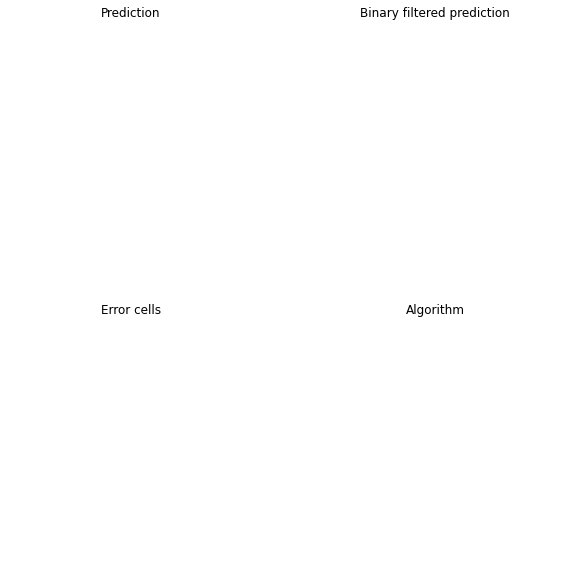

In [16]:
# settings for the animation 
gridsize = 30 # Size of the grid (n times n square, n must be divisible by 9)
gens = 100    # How many generations are animated
ival = 100    # frame interval in milliseconds (default 100 for 10 fps)
prediction_threshold = 0.5 #threshold for turning cell on in the prediction grid

# Create a random game grid of 50% density 
GAME = gol.generate(gridsize, 0.5)
GAME_NOFILTER = GAME #reference non-filtered prediction grid
GAME_REF = GAME #reference grid for GOL algorithm
ERRC = np.zeros((gridsize,gridsize)) 

def life_step_cnn_big(GRID):
    #create rim around the game area for torus-like operation
    expGame = np.pad(GRID,[(1,1),(1,1)], mode='wrap').reshape(1,gridsize+2,gridsize+2,1)
    preds = model_9.predict(expGame)
    return preds.reshape(gridsize,gridsize)

fig, axes = plt.subplots(2,2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,1]
ax4 = axes[1,0]

ax1.set_title("Prediction")
ax1.axis("off")
ax2.set_title("Binary filtered prediction")
ax2.axis("off")
ax3.set_title("Algorithm")
ax3.axis("off")
ax4.set_title("Error cells")
ax4.axis("off")
fig.set_size_inches(10, 10)

ims = []

# To print out relative time used in calculations with the trained model & original GOL algo
#%timeit life_step_cnn_big(GAME)
#%timeit gol.life_step_standard_rules(GAME)

#render generations
for g in range(0,gens):
    im = ax1.imshow(GAME_NOFILTER, animated=True)
    im2 = ax2.imshow(GAME, animated=True)
    im3 = ax3.imshow(GAME_REF, animated=True)
    im4 = ax4.imshow(ERRC, animated=True)
    ims.append([im, im2, im3, im4])
    GAME_NOFILTER = life_step_cnn_big(GAME)
    GAME = (GAME_NOFILTER > prediction_threshold).astype('int')
    GAME_REF = gol.life_step_standard_rules(GAME_REF)
    ERRC = (GAME != GAME_REF).astype('int')
    
anim = animation.ArtistAnimation(fig,ims,interval=ival)
HTML(anim.to_html5_video())

### Summary

So far so good - my initial assumption was that I'd be able to predict larger grids successfully with a Convolutional Neural Network, and it was certainly true. While testing with grids larger than 5x5, I noticed that it is possible to get enough accuracy for up to 30x30 grid without the learning getting too slow on CPU (about 100 seconds for the 30x30 grid). Trying to expand further, it would be necessary to iterate with the network architecture to reduce dimensionality - otherwise the number of params and training time will explode, as well as the inference time. 

With the model above, the prediction speed as compared to the traditional algorithm for 30x30 grid was about 5 times slower - somewhat in the same neighbourhood as when predicting just the single cells (see [GOL_NN.ipynb](GOL_NN.ipynb#Trained-Model-vs-Game-Of-Life-Algorithm---Performance-Evaluation)). => Perf-wise this is not leading to a win 😕. It was a great exercise in Keras and building convnet models from scratch though.

It might be interesting to iterate further with e.g. a 50x50 grid and try to find a CNN architecture that would have both high accuracy and high performance. Output dimensionality of 2500 would not be gigantic yet. However, this problem is something that will not scale properly due to the fact that the output tensor will grow exponentially as input grows, and it is not possible to resize the input tensors as you can easily do with e.g. image recognition without severely compromising the classification task.

Therefore I'm going to move towards a new problem in the next notebook, where I will make my attempt on the kaggle.net [backwards prediction challenge](https://www.kaggle.com/c/conway-s-reverse-game-of-life) published in 2014. The kaggle challenge is no longer active, but I believe that browsing the related discussion board will provide enough inspiration for getting started. 

**Next**: [Recurrent Neural Net](GOL_RNN.ipynb)